<a href="https://colab.research.google.com/github/fdeloscogna/Python_experiment/blob/main/Tesi_Python_section.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification running resnet50 pre-trained model

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
from torchvision import transforms
from torchvision.models import *
from sklearn.utils import class_weight
from torch.utils.data import DataLoader,Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, MaxPooling2D
from tensorflow.keras.models import Model
from torchvision import models,transforms
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

import matplotlib.pyplot as plt

import seaborn as sns

import random
#Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the function to set the seeds
set_seeds()

Mounted at /content/drive


In [2]:
# Setting the device
if torch.cuda.is_available():
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
    print('"Runtime" --> "Change runtime type" --> "Hardware accelerator" --> "GPU" --> "Save"')
    device = torch.device("cpu")

GPU enabled!


In [3]:
#Import the dataset available
image_directory = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification'
labels_file_path = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification/labels.csv'
#read the labeled data
labeled_data = pd.read_csv(labels_file_path)
# Read the CSV file containing the labels into a Pandas DataFrame and store it in labeled_data.
# Get the labeled image filenames and their corresponding labels
labeled_filenames = labeled_data['id'].astype(str).values
labels = labeled_data['malignant'].values + 1

In [ ]:
#Let's define a proper list of the labeled images
#3 classes are available, 1, 0, -1
tr = pd.read_csv(os.path.join(image_directory,'labels.csv'))
tr['Image_id'] = ''
for i in range(len(tr)):
  tr['Image_id'][i] = 'img_' + str(tr.loc[i, ('id')]) + '.png'
tr.head()

<ipython-input-4-37b977ffbd52>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr['Image_id'][i] = 'img_' + str(tr.loc[i, ('id')]) + '.png'


,id,malignant,Image_id
0,441,-1,img_441.png
1,33284,-1,img_33284.png
2,38771,1,img_38771.png
3,46784,-1,img_46784.png
4,57613,-1,img_57613.png


Deal with data transformation

In [4]:
#Non labeled
os.chdir("/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification")
!ls

img_103601.png	img_295118.png	img_486254.png	img_714933.png	img_848963.png
img_105480.png	img_296778.png	img_491249.png	img_724277.png	img_861469.png
img_112905.png	img_298233.png	img_49868.png	img_727330.png	img_863080.png
img_118847.png	img_303169.png	img_5042.png	img_731663.png	img_868794.png
img_125877.png	img_308363.png	img_505739.png	img_732824.png	img_869706.png
img_131043.png	img_310272.png	img_51083.png	img_734235.png	img_87519.png
img_133778.png	img_314793.png	img_511419.png	img_739490.png	img_877012.png
img_133962.png	img_321503.png	img_520490.png	img_741219.png	img_879144.png
img_135878.png	img_322111.png	img_531231.png	img_74682.png	img_885489.png
img_136044.png	img_33284.png	img_534691.png	img_74995.png	img_900056.png
img_139077.png	img_333275.png	img_556033.png	img_754446.png	img_901399.png
img_145106.png	img_341818.png	img_557108.png	img_755969.png	img_906866.png
img_150775.png	img_346084.png	img_557633.png	img_757632.png	img_912471.png
img_156941.png	img_347283.png	img

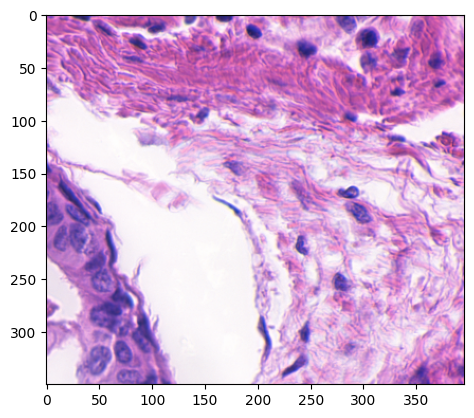

In [ ]:
#Show here the image of the tissue
img = Image.open('img_441.png')
plt.imshow(img)

In [5]:
#Let's impose a custom dataset CustomDataset class is designed to be flexible,
#To provide filenames and labels explicitly or read them from a CSV file because It supports image transformations for data augmentation
class CustomDataset(Dataset):
    def __init__(self, image_directory, labels_file_path, transform=None, provided_filenames=None, provided_labels=None):
        """
        CustomDataset builder section.
        Parameters considered in the function:
        - transform (callable, optional): here it is a optional transform to be applied to the images.
        - provided_filenames (list, optional): List of filenames corresponding to the images.
        - provided_labels (list, optional): List of labels corresponding to the images.
        """
        self.image_directory = image_directory
        self.labels_df = pd.read_csv(labels_file_path)
        self.transform = transform

        # Use provided filenames and labels if available
        if provided_filenames is not None and provided_labels is not None:
            self.filenames = provided_filenames
            self.labels = provided_labels
            self.use_additional_data = True
        else:
            self.filenames = self.labels_df['id'].astype(str).values
            self.labels = self.labels_df['malignant'].values + 1
            self.use_additional_data = False

    def __len__(self):
        """
        The folowing part it gives the number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset.
        Parameters:
        - idx (int): Index of the item to retrieve.
        """
        if self.use_additional_data:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.filenames[idx]) + '.png')
        else:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.labels_df.iloc[idx]['id']) + '.png')

        image = Image.open(img_path).convert('RGB')
        #Since, from literature, many machine learning models and image processing libraries expect images to be in RGB format for consistency.
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        #It return here a tuble with the image and its label
        return image, label

In [6]:
max_width = 0
max_height = 0
# Initialize variables to store the maximum width and height of the images.

for file_name in labeled_filenames:
    file_path = os.path.join(image_directory, "img_" + file_name + '.png')
    image = Image.open(file_path)
    width, height = image.size
    max_width = max(max_width, width)
    max_height = max(max_height, height)
    '''
    Iterate over the labeled_filenames and open each image using PIL.
    Get the width and height of each image and update the maximum width and height if necessary.
    '''

In [7]:
# Define the main data transform
main_transform = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

'''
Create a transformation pipeline using transforms compose.
The pipeline resizes the images to the maximum width and height found earlier,
converts them to tensors, and applies normalization.
'''

# Create the main dataset
dataset = CustomDataset(image_directory, labels_file_path, transform=main_transform)

'''
Create an instance of the CustomDataset class using the image_dir, labels_file,
and the main_transform defined above.
'''

# Define data augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

'''
Create another transformation pipeline for data augmentation.
The pipeline includes resizing, random horizontal and vertical flips,
random rotation, color jitter, tensor conversion, and normalization.
'''

dataset_augmented = CustomDataset(image_directory, labels_file_path, transform=augmentation_transform)
'''
Create another instance of the CustomDataset class using the image_dir, labels_file,
and the augmentation_transform defined above.
'''

# Define data augmentation transforms 2
augmentation_transform_2 = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((max_height, max_width), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
'''
Create a third transformation pipeline for more data augmentation.
The pipeline includes resizing, random horizontal and vertical flips,
random rotation, color jitter, random affine transformation, random resized crop,
random perspective, tensor conversion, and normalization.
'''

dataset_augmented_2 = CustomDataset(image_directory, labels_file_path, transform=augmentation_transform_2)
'''
Create another instance of the CustomDataset class using the image_dir, labels_file,
and the augmentation_transform_2 defined above.
'''

stacked_dataset = ConcatDataset([dataset, dataset_augmented])
'''
Combine the main dataset and the augmented dataset using ConcatDataset.
This creates a single dataset that contains both original and augmented data.
'''

stacked_labels = np.concatenate([labels, labels])
'''
Concatenate the labels array with itself to match the combined dataset size.
This ensures that the labels are aligned with the corresponding images in stacked_dataset.
'''

# Define the number of folds for k-fold cross-validation
k_folds = 8
# Specify the number of folds to use for k-fold cross-validation.


# Perform k-fold cross-validation
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
'''
Create an instance of StratifiedKFold, which performs stratified k-fold cross-validation.
It splits the data into k folds while preserving the class distribution.
The shuffle parameter is set to True to shuffle the data before splitting,
and the random_state is set to 42 for reproducibility.
'''

fold_scores = []
# Create an empty list to store the scores for each fold.


for fold, (train_index, val_index) in enumerate(skf.split(stacked_dataset, stacked_labels)):
    # Iterate over each fold generated by the StratifiedKFold object.

    print(f"Training on fold {fold + 1}/{k_folds}")

    # Split the dataset into train and validation sets for the current fold
    train_data = [stacked_dataset[idx] for idx in train_index]
    val_data = [stacked_dataset[idx] for idx in val_index]
    '''
    Obtain the indices for the training and validation data for the current fold
    and extract the corresponding data from the stacked_dataset.
    '''

    # Convert labels to numpy array for indexing
    stacked_labels = np.array(stacked_labels)
    # Convert the stacked_labels to a numpy array for easier indexing.


    # Calculate class weights
    class_weights = 1.0 / torch.tensor(np.bincount(stacked_labels[train_index]))
    '''
    Compute the class weights by taking the reciprocal of the counts of each class in the training set.
    This gives more weight to underrepresented classes and less weight to overrepresented classes.
    '''
    train_class_weights = class_weights[stacked_labels[train_index]]
    # Extract the class weights corresponding to the training labels.


    # Create the weighted sampler
    sampler = WeightedRandomSampler(train_class_weights, len(train_data), replacement=True)
    '''
    Create a WeightedRandomSampler, which samples elements from the training data with replacement
    according to the specified class weights. This oversamples the underrepresented classes
    during training to balance the class distribution.
    '''

    # Create the data loaders with weighted sampling
    batch_size = 8
    train_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
    # Create a DataLoader for the training data, using the WeightedRandomSampler to sample batches.
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    # Create a DataLoader for the validation data without sampling, shuffling the data within each epoch is not needed in validation.

Training on fold 1/8
Training on fold 2/8
Training on fold 3/8
Training on fold 4/8
Training on fold 5/8
Training on fold 6/8
Training on fold 7/8
Training on fold 8/8


In [ ]:
##################################################
# Visualize Image Augmentation
##################################################
'''
for k, v in tr.items():
  print(k)
  plt.figure(figsize=(25, 20))
  for idx in range(20):
      plt.subplot(1, 20, idx + 1)
      #img = np.array(v[idx].reshape(28,28))
      #plt.title(f'{y_labels[new_y_test[idx]]}')
      img_path = os.path.join(image_directory, 'img_' + str(labels_df.iloc[idx]['id']) + '.png')
      plt.imshow(img_path, cmap='gray')
      plt.axis('off')
  plt.show()
  '''

Resnet Pre trained model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - ResNet50 Training Loss: 1.1933
Epoch 2/10 - ResNet50 Training Loss: 1.0787
Epoch 3/10 - ResNet50 Training Loss: 1.0236
Epoch 4/10 - ResNet50 Training Loss: 0.8880
Epoch 5/10 - ResNet50 Training Loss: 0.8312
Epoch 6/10 - ResNet50 Training Loss: 0.8706
Epoch 7/10 - ResNet50 Training Loss: 0.8575
Epoch 8/10 - ResNet50 Training Loss: 0.7920
Epoch 9/10 - ResNet50 Training Loss: 0.6962
Epoch 10/10 - ResNet50 Training Loss: 0.7827


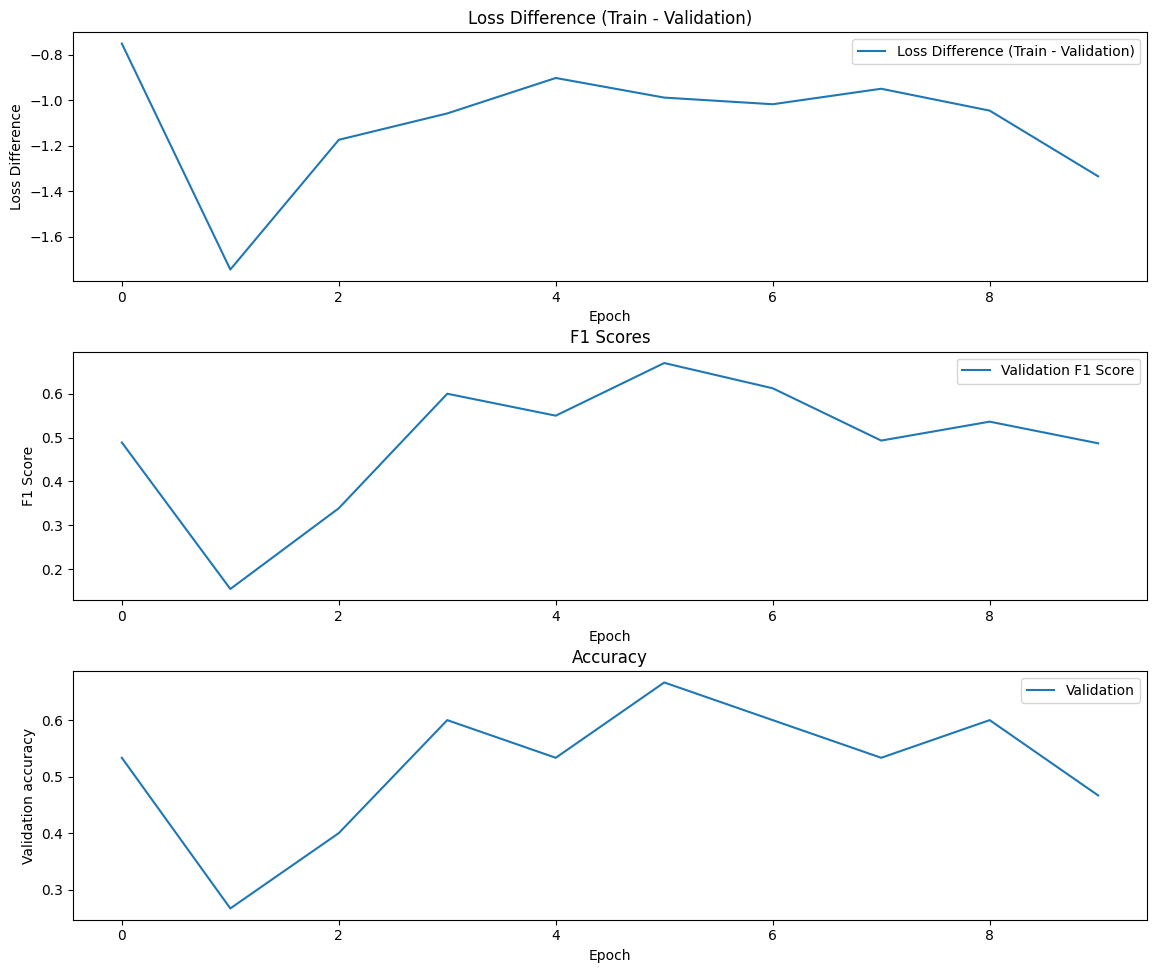

In [23]:
# Load pre-trained models
resnet_model = models.resnet50(pretrained=True)

# Freeze all the parameters of the pretrained model
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match the number of classes
num_classes = 3
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Move the model to the device (GPU if available)
resnet_model = resnet_model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)
#optimizer_resnet = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

# Initialize subplots
fig, axs = plt.subplots(3,1, figsize=[12, 10])  # Two rows and two columns of subplots
fig.tight_layout(pad=3.0)

# Lists to store training and validation losses and F1 scores
train_losses = []
val_losses = []
val_accuracies_pre = []
val_f1_scores_pre = []

# Training loop
num_epochs = 10  # Replace with the actual number of epochs
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()

        outputs = resnet_model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} - ResNet50 Training Loss: {epoch_loss:.4f}")

    # Validation phase
    resnet_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_loss = criterion(resnet_outputs, labels)

            val_loss += resnet_loss.item()

            _, predictions = torch.max(resnet_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    # Append the loss values to the respective lists
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    val_loss /= len(val_dataloader)

    val_f1_pre = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_pre = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_pre.append(val_f1_pre)      # Replace with actual validation F1 score
    val_accuracies_pre.append(val_accuracy_pre)      # Replace with actual validation accuracy

loss_difference = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

# Plot the loss difference
axs[0].plot(loss_difference, label='Loss Difference (Train - Validation)')
axs[0].set_title('Loss Difference (Train - Validation)')
axs[0].set_ylabel('Loss Difference')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot training and validation F1 scores
axs[1].plot(val_f1_scores_pre, label='Validation F1 Score')
axs[1].set_title('F1 Scores')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].legend()

#Accuracy
axs[2].plot(val_accuracies_pre, label='Validation')
axs[2].set_title('Accuracy')
axs[2].set_ylabel('Validation accuracy')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Show or save the plot as needed
plt.show()

Parte con VGG16

In [9]:
weight = models.VGG16_Weights.DEFAULT
pre_model = models.vgg16(weights = weight)

# Freeze all the parameters of the pretrained models
for param in pre_model.parameters():
    param.requires_grad = False

num_classes = 3
last_item_index = len(pre_model.classifier) - 1
old_fc = pre_model.classifier.__getitem__(last_item_index)
new_fc = nn.Linear(in_features=old_fc.in_features,
                   out_features= num_classes, bias=True)
pre_model.classifier.__setitem__(last_item_index , new_fc)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 157MB/s]


In [10]:
pre_model = pre_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(pre_model.parameters(), lr=0.001)
best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

In [21]:
# Lists to store training and validation F1 scores and accuracies
val_f1_scores_vgg = []
train_accuracies = []
val_accuracies_vgg = []
train_losses = []
val_losses = []  # Initialize an empty list to store validation accuracies

Epoch 1/15 - VGG 16 Training Loss: 0.3194
Epoch 1/15 - Validation Loss: 0.8883, F1 Score: 0.5867, Accuracy: 0.6000
Epoch 2/15 - VGG 16 Training Loss: 0.3995
Epoch 2/15 - Validation Loss: 0.8469, F1 Score: 0.5800, Accuracy: 0.6000
Epoch 3/15 - VGG 16 Training Loss: 0.2703
Epoch 3/15 - Validation Loss: 0.9127, F1 Score: 0.5256, Accuracy: 0.5333
Epoch 4/15 - VGG 16 Training Loss: 0.3465
Epoch 4/15 - Validation Loss: 0.9903, F1 Score: 0.5800, Accuracy: 0.6000
Epoch 5/15 - VGG 16 Training Loss: 0.3033
Epoch 5/15 - Validation Loss: 0.9520, F1 Score: 0.5800, Accuracy: 0.6000
Epoch 6/15 - VGG 16 Training Loss: 0.3416
Epoch 6/15 - Validation Loss: 0.9366, F1 Score: 0.5800, Accuracy: 0.6000
Epoch 7/15 - VGG 16 Training Loss: 0.2970
Epoch 7/15 - Validation Loss: 1.0264, F1 Score: 0.5800, Accuracy: 0.6000
Epoch 8/15 - VGG 16 Training Loss: 0.3260
Epoch 8/15 - Validation Loss: 1.0152, F1 Score: 0.5256, Accuracy: 0.5333
Epoch 9/15 - VGG 16 Training Loss: 0.3723
Epoch 9/15 - Validation Loss: 1.1446, 

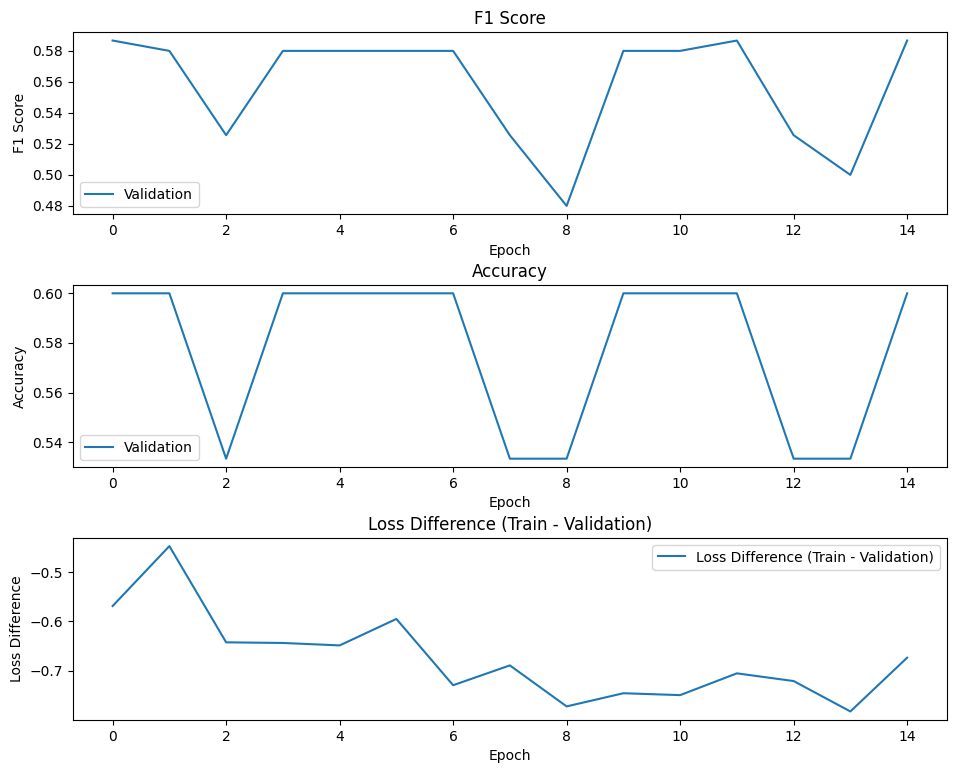

In [22]:
fig, axs = plt.subplots(3, 1, figsize=[10, 8])  # Two subplots for F1 score and accuracy
fig.tight_layout(pad=3.0)

num_epochs = 15
# Set the number of training epochs.
for epoch in range(num_epochs):
    # Training phase for ResNet50
    pre_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
        # Initialize the confusion matrix.
        # Move the images and labels to the specified device (GPU if available).

        optimizer_vgg.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = pre_model(images)
        # Perform a forward pass of the images through the ResNet50 model to get the outputs.

        loss = criterion(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_vgg.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - VGG 16 Training Loss: {epoch_loss:.4f}")

    # Print the training loss for the current epoch.
    # Validation phase
    pre_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            premodel_outputs = pre_model(images)
            premodel_loss = criterion(premodel_outputs, labels)

            val_loss += premodel_loss.item()

            _, predictions = torch.max(premodel_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)


            # Calculate the F1 score and update the confusion matrix
            confusion += confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=range(num_classes))
    #print("Confusion Matrix:")
    #print(confusion)

    val_loss /= len(val_dataloader)

    val_f1_vgg = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy_vgg = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_vgg.append(val_f1_vgg)      # Replace with actual validation F1 score
    val_accuracies_vgg.append(val_accuracy_vgg)      # Replace with actual validation accuracy
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1_vgg:.4f}, Accuracy: {val_accuracy_vgg:.4f}")
loss_difference = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

# Plot the loss difference
axs[2].plot(loss_difference, label='Loss Difference (Train - Validation)')
axs[2].set_title('Loss Difference (Train - Validation)')
axs[2].set_ylabel('Loss Difference')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Plot learning curves for F1 score
axs[0].plot(val_f1_scores_vgg, label='Validation')
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot learning curves for accuracy
axs[1].plot(val_accuracies_vgg, label='Validation')
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# Show or save the plot as needed
plt.show()

Google Net

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=[10, 8])  # Two subplots for F1 score and accuracy
fig.tight_layout(pad=3.0)

# Lists to store training and validation F1 scores and accuracies
val_f1_scores_google = []
train_accuracies = []
val_accuracies_score_google = []
train_losses = []
val_losses = []

pesigoogle = models.GoogLeNet_Weights.DEFAULT
googlenet_model = models.googlenet(weights=pesigoogle)
num_classes = 3
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model = googlenet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam(googlenet_model.parameters(), lr=0.001)
best_val_loss = float('inf')
best_val_f1 = 0.0
best_val_acc = 0.0

num_epochs = 15
for epoch in range(num_epochs):
    # Training phase for GoogLeNet
    googlenet_model.train()
    # Set the model to train mode.
    running_loss = 0.0
    # Initialize the running loss for the current epoch.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Move the images and labels to the specified device (GPU if available).

        optimizer_googlenet.zero_grad()
        # Clear the gradients from the previous iteration.

        outputs = googlenet_model(images)
        # Perform a forward pass of the images through the GoogLeNet model to get the outputs.

        loss = criterion(outputs, labels)
        # Compute the loss by comparing the model outputs with the ground truth labels.

        loss.backward()
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters.

        optimizer_googlenet.step()
        # Update the model parameters based on the computed gradients using the optimizer.

        running_loss += loss.item()
        # Accumulate the running loss for the current epoch.

    epoch_loss = running_loss / len(train_dataloader)
    # Calculate the average loss for the current epoch.

    print(f"Epoch {epoch+1}/{num_epochs} - GoogLeNet Training Loss: {epoch_loss:.4f}")
    # Print the training loss for the current epoch.

    googlenet_model.eval()

    val_loss = 0.0
    # Initialize the validation loss.
    val_f1 = 0.0
    # Initialize the F1 score.
    val_accuracy = 0.0
    # Initialize the accuracy.
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total labels.
    confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    # Initialize the confusion matrix.

    with torch.no_grad():
        # Disable gradient computation since no backward pass is needed during validation.
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Move the images and labels to the specified device (GPU if available).

            # GoogLeNet
            googlenet_outputs = googlenet_model(images)
            googlenet_loss = criterion(googlenet_outputs, labels)
            # Compute the loss for the GoogLeNet model.

            # Combine losses
            loss = (googlenet_loss)
            # Combine the losses from all models by taking their average.

            val_loss += loss.item()
            # Accumulate the validation loss.

            # Calculate accuracy
            _, predictions = torch.max((googlenet_outputs), dim=1)
            # Combine the predictions from all models by taking their average and get the class with the maximum score.

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)
            # Concatenate the predictions and labels to the total tensors.

            # Calculate the F1 score and update the confusion matrix
            confusion += confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=range(num_classes))

    val_loss /= len(val_dataloader)
    # Calculate the average validation loss.

    val_f1_google = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')
    # Calculate the F1 score.

    val_accuracy_google = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Calculate the accuracy.

    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1_google:.4f}, Accuracy: {val_accuracy_google:.4f}")
    #print("Confusion Matrix:")
    #print(confusion)
    # Print the validation loss, F1 score, and accuracy for the current epoch.

    # Define class labels (replace with your actual class labels)
    #class_labels = ['-1', '0', '1',]


    # Append F1 scores and accuracies to the respective lists
    val_f1_scores_google.append(val_f1_google)      # Replace with actual validation F1 score
    val_accuracies_score_google.append(val_accuracy_google)      # Replace with actual validation accuracy
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

loss_difference = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

# Plot the loss difference
axs[2].plot(loss_difference, label='Loss Difference (Train - Validation)')
axs[2].set_title('Loss Difference (Train - Validation)')
axs[2].set_ylabel('Loss Difference')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Plot learning curves for F1 score
axs[0].plot(val_f1_scores_google, label='Validation')
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot learning curves for accuracy
axs[1].plot(val_accuracies_score_google, label='Validation')
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# Show or save the plot as needed
plt.show()

Plotting the 3 results and show the differences

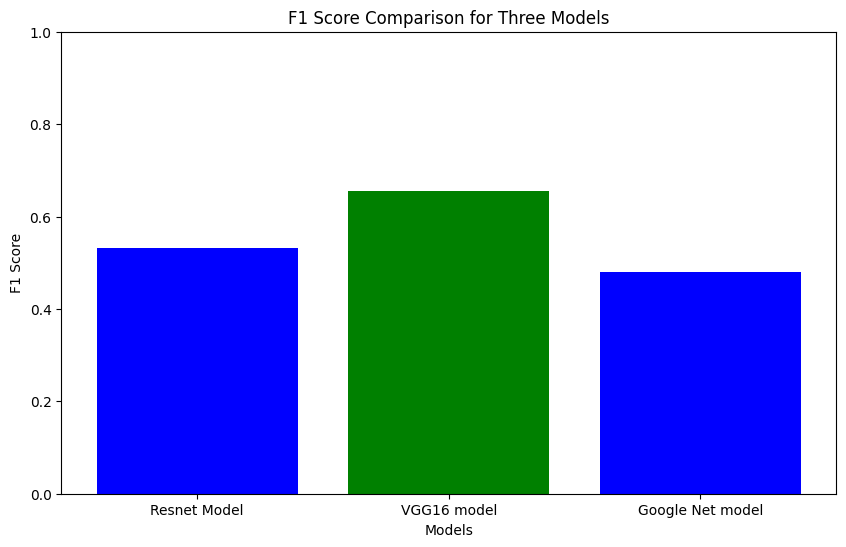

In [28]:
model_names = ['Resnet Model', 'VGG16 model', 'Google Net model']
f1_scores = []

f1_scores.append(val_f1_pre)
f1_scores.append(val_f1_vgg)
f1_scores.append(val_f1_google)

best_model_idx = f1_scores.index(max(f1_scores))
best_model_name = model_names[best_model_idx]

plt.figure(figsize=(10, 6))

colors = ['blue' if model != best_model_name else 'green' for model in model_names]

plt.bar(model_names, f1_scores, color=colors)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison for Three Models')
plt.ylim(0, 1)
plt.show()

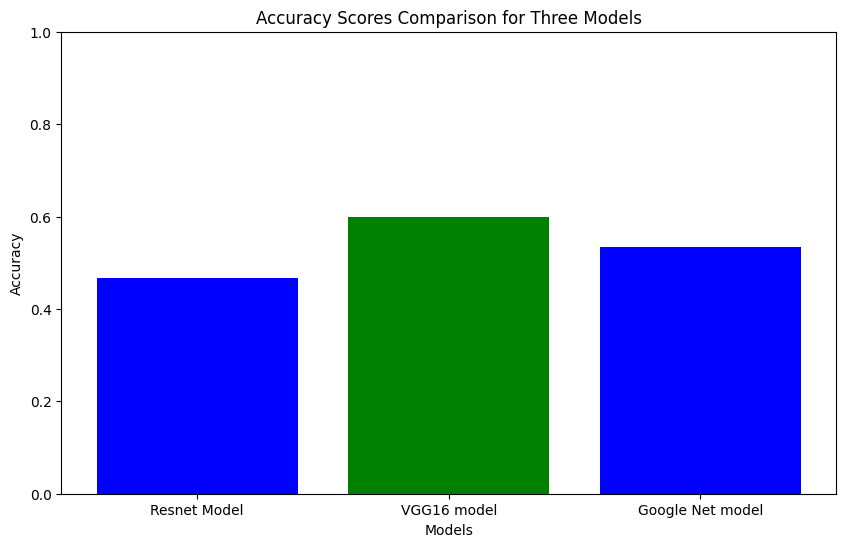

In [24]:
##################################################
# MODEL ACCURACY COMPARISON
##################################################

model_names = ['Resnet Model', 'VGG16 model', 'Google Net model']
accuracy_scores = []

accuracy_scores.append(val_accuracy_pre)
accuracy_scores.append(val_accuracy_vgg)
accuracy_scores.append(val_accuracy_google)

best_model_idx = accuracy_scores.index(max(accuracy_scores))
best_model_name = model_names[best_model_idx]

plt.figure(figsize=(10, 6))

colors = ['blue' if model != best_model_name else 'green' for model in model_names]

plt.bar(model_names, accuracy_scores, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores Comparison for Three Models')
plt.ylim(0, 1)
plt.show()

In [ ]:
##################################################
# Plot Learning Curves of Training and Validation
##################################################

# Initialize subplots
fig, axs = plt.subplots(2,4, figsize = [20,8])
fig.tight_layout(pad=3.0)

# Loop through each model history to plot loss and accuracy learning curves
model_idx = 0
for model_key, history in history_dict.items():

  if 'ann' in model_key:

    # Plot learning curves for loss
    axs[0,model_idx].plot(history.history['loss'])
    axs[0,model_idx].plot(history.history['val_loss'])
    axs[0,model_idx].set_title('{} - LOSS'.format(model_key.upper()))
    axs[0,model_idx].set_ylabel('loss')
    axs[0,model_idx].set_xlabel('epoch')
    axs[0,model_idx].legend(['train', 'test'], loc='upper left')

    # Plot learning curves for accuracy
    axs[1,model_idx].plot(history.history['accuracy'])
    axs[1,model_idx].plot(history.history['val_accuracy'])
    axs[1,model_idx].set_title('{} - ACCURACY'.format(model_key.upper()))
    axs[1,model_idx].set_ylabel('accuracy')
    axs[1,model_idx].set_xlabel('epoch')
    _ = axs[1,model_idx].legend(['train', 'test'], loc='upper left')

    model_idx += 1
    # plt.savefig('/data/{}/ann_learning_curves_{}.png'.format(model_iter,model_iter))